The goal here islook at the airmass limit in \ttt{pontus\_2002} at three declinations: northern limit of current baseline (`kraken_2026`), middle of the proposed WFD extension, and the northern limit of the extension.

For the three declinations, we calculate the median airmass, seeing, and per visit/exposure depth across all RA. All these numbers are calculated from `pontus_2002` to provide scaling of the 4 statistics for the different declinations.

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import os
import healpy as hp
import numpy as np
import pandas as pd
import lsst.sims.maf.metricBundles as metricBundles
import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.metrics as metrics
import lsst.sims.maf.db as db
import lsst.sims.maf.stackers as stackers

In [2]:
fontsize = 16
mpl.rcParams['axes.labelsize'] = fontsize
mpl.rcParams['xtick.labelsize'] = fontsize-2
mpl.rcParams['ytick.labelsize'] = fontsize-2
mpl.rcParams['axes.titlesize'] = fontsize
mpl.rcParams['axes.linewidth'] = 2
mpl.rcParams['figure.titlesize'] = fontsize
mpl.rcParams['legend.fontsize'] = fontsize-2

import warnings
warnings.filterwarnings('ignore')

**Read in the coadd data for the kraken_2026 and find all-band footprint**

In [3]:
# data characteristics
nside = 256

# path + tags to read in coadd data for kraken2016; saved data has masks for each band.
# needed to figure out the upper "edge" of the footprint
file_yearTag = 'fullSurveyPeriod'
dbname = 'kraken_2026'
coadd_data_dir = '/global/cscratch1/sd/awan/lsst_output/coadd_output_allwps_perNight/'

# Read in the coadd data for the kraken_2026
data_bundle = {}   
for band in ['u', 'g', 'r', 'i', 'z', 'y']:
    # set up the folders
    folder = 'coaddM5Analysis_nside%s_withDustExtinction_'%(nside)
    folder += '0pixelRadiusForMasking_%sBand_%s_%s_directory/'%(band, dbname, file_yearTag)
    path = '%s/%s/unmaskedCoaddData/'%(coadd_data_dir, folder)
    # get the filenames
    filenames = [f for f in os.listdir(path) if f.endswith('.npz')]
    print('Reading %s from\n%s/unmaskedCoaddData.\n'%(filenames, folder))

    if len(filenames)>1:
        err = 'Have more than one npz file for %s band'%band
        err += ' for %s data: %s'%(yr_cut, filenames)
        raise ValueError(err)
    else:
        dither = filenames[0].split('%s_'%band)[-1]
        dither = dither.split('.npz')[0]
        mB = metricBundles.createEmptyMetricBundle()
        mB.read('%s/%s'%(path, filenames[0]))
        data_bundle['%s'%(band)]= mB

# find all-band footprint
all_band_pixels = None

for band in data_bundle:
    index = np.where((data_bundle[band].metricValues.mask == False) & \
                     (data_bundle[band].metricValues.data > 0))[0]
    # save the indices
    if all_band_pixels is None:
        # initate the list
        all_band_pixels = index
    else:
        # keep only the overlapping pixels
        all_band_pixels = list(set(all_band_pixels).intersection(index))
        
all_band_pixels = np.array(all_band_pixels)

Reading ['coaddM5Data_unmasked_u_RandomDitherPerNight.npz'] from
coaddM5Analysis_nside256_withDustExtinction_0pixelRadiusForMasking_uBand_kraken_2026_fullSurveyPeriod_directory//unmaskedCoaddData.

Healpix slicer using NSIDE=256, approximate resolution 13.741946 arcminutes
Reading ['coaddM5Data_unmasked_g_RandomDitherPerNight.npz'] from
coaddM5Analysis_nside256_withDustExtinction_0pixelRadiusForMasking_gBand_kraken_2026_fullSurveyPeriod_directory//unmaskedCoaddData.

Healpix slicer using NSIDE=256, approximate resolution 13.741946 arcminutes
Reading ['coaddM5Data_unmasked_r_RandomDitherPerNight.npz'] from
coaddM5Analysis_nside256_withDustExtinction_0pixelRadiusForMasking_rBand_kraken_2026_fullSurveyPeriod_directory//unmaskedCoaddData.

Healpix slicer using NSIDE=256, approximate resolution 13.741946 arcminutes
Reading ['coaddM5Data_unmasked_i_RandomDitherPerNight.npz'] from
coaddM5Analysis_nside256_withDustExtinction_0pixelRadiusForMasking_iBand_kraken_2026_fullSurveyPeriod_directory//

**Find the declination of the upper edge of the baseline footprint**

In [4]:
def plot_skymap(arr, title=''):
    # plot the skymap
    plt.clf()
    hp.mollview(arr, flip='astro', rot=(0,0,0), title=title)
    hp.graticule(dpar=20, dmer=20, verbose=False)
    plt.gcf().set_size_inches(6, 6)
    plt.show()
    
def pix_to_radec(pixels, nside):
    lat, ra = hp.pix2ang(ipix=pixels, nside=nside)
    ra = np.remainder(ra+np.pi*2, np.pi*2)
    dec = np.pi/2.0 - lat
    return np.rad2deg(ra), np.rad2deg(dec)

Lets plot the all-band skymap to ensure things are working

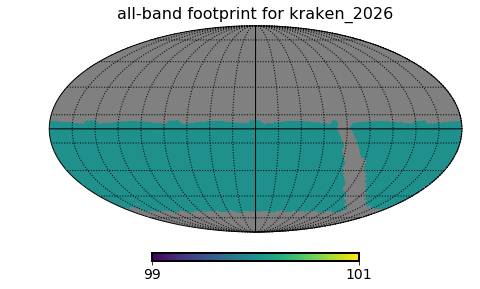

In [5]:
npix = hp.nside2npix(nside)
val = np.zeros(npix)+1.
footprint = val.view(np.ma.MaskedArray)
footprint.mask = [True]*npix
footprint.fill_value = np.nan
footprint.mask[all_band_pixels] = False
footprint.data[all_band_pixels] = 100

plot_skymap(footprint, title='all-band footprint for kraken_2026')

Now lets find the max declination that'd work for us

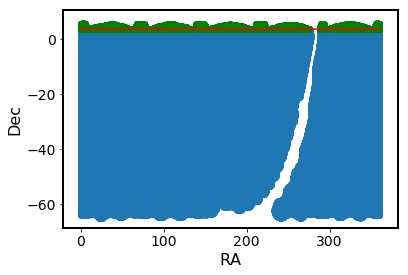

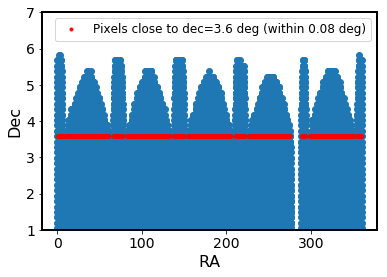

In [6]:
# plot the ra, dec corresponding on the all-band pixels
ras, decs = pix_to_radec(pixels=all_band_pixels, nside=nside)
plt.scatter(ras, decs)
# plot a line for a declination
max_dec = 3.6
border_pix = np.where(decs>=max_dec)[0]
plt.scatter(ras[border_pix], decs[border_pix], color='g')

plt.plot([0, 360], [max_dec, max_dec], 'r-')
plt.xlabel('RA')
plt.ylabel('Dec')
plt.show()

# plot the pixels that are close to the proposed declination
plt.clf()
plt.scatter(ras, decs)
tol = 0.08
ind = np.where((abs(decs-max_dec)<tol))[0]
dec_pix = all_band_pixels[ind]
x, y = pix_to_radec(pixels=dec_pix, nside=nside)
plt.plot(x, y, 'r.', label='Pixels close to dec=%s deg (within %s deg)'%(max_dec, tol))
plt.ylim(1,7)
plt.legend(loc="best", fontsize=12)
plt.xlabel('RA')
plt.ylabel('Dec')
plt.show()

Okay, now that we have the (~) edge of the baseline footprint, we can look at the other two declinations. We know that max declination for the new footprint is 12.5 degrees, so there's no calculation to be done, and we can easily find the midpoint betwee the two.

In [7]:
baseline_maxdec = 3.6
new_maxdec = 12.5
dec_lims = [baseline_maxdec, baseline_maxdec + (new_maxdec-baseline_maxdec)/2., new_maxdec]
print('Looking at declinations = %s'%(dec_lims,))

Looking at declinations = [3.6, 8.05, 12.5]


**Read in the `pontus_2002` database and calculate statistics for observations across different RAs for the three declinations**

In [8]:
dbname = 'pontus_2002'
dbpath = '/global/cscratch1/sd/awan/dbs_wp_unzipped/pontus_2002.db'

In [9]:
%%time
# connect to the database
opsdb = db.OpsimDatabase(dbpath)
# ----------------------------------------------------------
# WFD only
prop_ids, prop_tags = opsdb.fetchPropInfo()
wfd_constraint = opsdb.createSQLWhere('WFD', prop_tags)

# fetch the data: columns need for the rotational dither and parallactic angle stacker
colnames=['fieldRA', 'fieldDec', 'fieldId', 'airmass', 'night', 'filter', \
          'seeingFwhm500', 'seeingFwhmGeom', 'seeingFwhmEff', \
          'fiveSigmaDepth', 'numExposures']
simdata = opsdb.fetchMetricData(colnames=colnames, sqlconstraint=wfd_constraint)

# ----------------------------------------------------------
# add rotational dithers: adds randomDitherPerFilterChangeRotTelPos column to simdata
s = stackers.RandomDitherPerNightStacker(degrees=opsdb.raDecInDeg, randomSeed=42)
simdata = s.run(simdata)

CPU times: user 1min 48s, sys: 9.45 s, total: 1min 58s
Wall time: 1min 58s


**Okay now lets get the WFD visits for different bands, find all the visits to each of the three declinations (within some tolerance) and calculate median statistics**

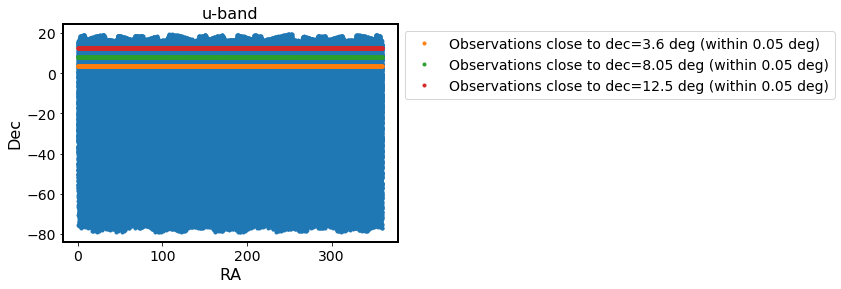

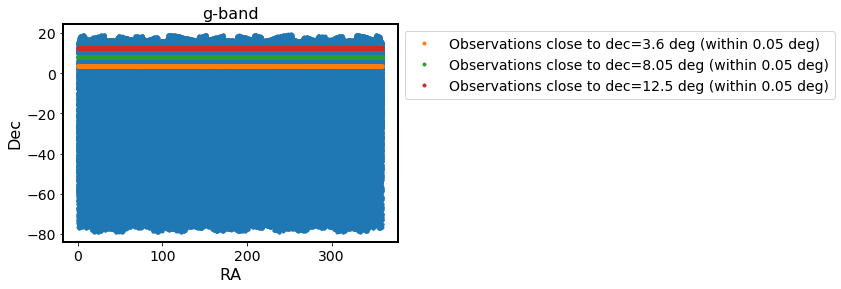

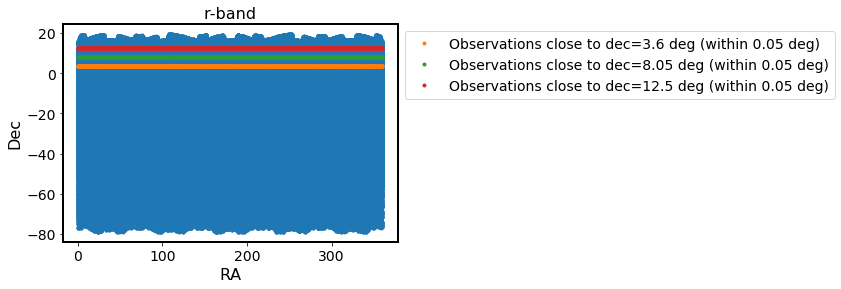

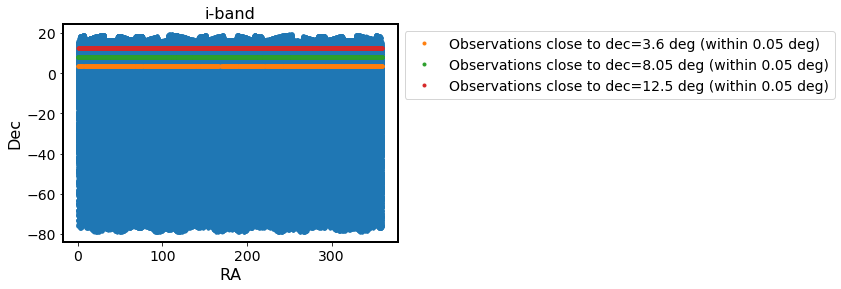

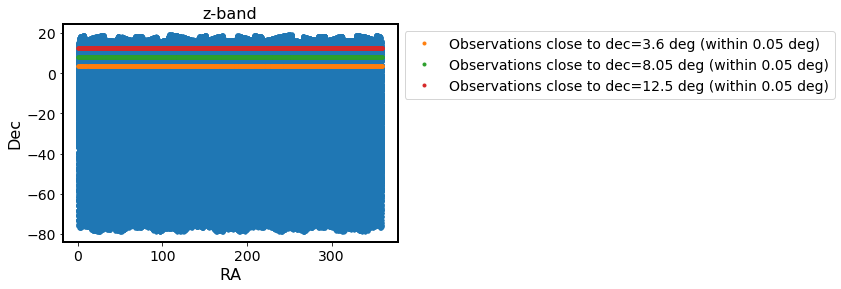

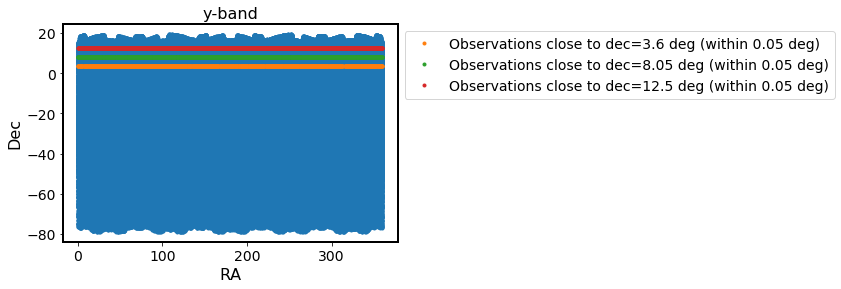

| band |  dec | Median airmass | Median seeingFwhm500 | Median seeingFwhmGeom | Median seeingFwhmEff | Median fiveSigmaDepth |
|:----:|:----:|:----:|:----:|:----:|:----:|:----:|
| u | 3.6 | 1.209 | 0.609 | 0.783 | 0.889 | 23.490 |
| u | 8.05 | 1.281 | 0.609 | 0.804 | 0.915 | 23.398 |
| u | 12.5 | 1.365 | 0.604 | 0.834 | 0.951 | 23.338 |
| ---- | ---- |  ---- | ---- | ---- | ---- | ---- |
| g | 3.6 | 1.208 | 0.610 | 0.783 | 0.889 | 23.241 |
| g | 8.05 | 1.281 | 0.609 | 0.805 | 0.917 | 23.107 |
| g | 12.5 | 1.363 | 0.604 | 0.834 | 0.951 | 23.028 |
| ---- | ---- |  ---- | ---- | ---- | ---- | ---- |
| r | 3.6 | 1.209 | 0.608 | 0.784 | 0.890 | 23.026 |
| r | 8.05 | 1.281 | 0.613 | 0.808 | 0.919 | 22.878 |
| r | 12.5 | 1.366 | 0.603 | 0.835 | 0.952 | 22.809 |
| ---- | ---- |  ---- | ---- | ---- | ---- | ---- |
| i | 3.6 | 1.209 | 0.612 | 0.795 | 0.904 | 23.023 |
| i | 8.05 | 1.281 | 0.611 | 0.817 | 0.930 | 22.913 |
| i | 12.5 | 1.364 | 0.613 | 0.851 | 0.972 | 22.769 |
| ---- | ---- |  ---- 

In [10]:
header = '| band | '
header2 = '|:----:|'

allrows = ''
for i, band in enumerate(['u', 'g', 'r', 'i', 'z', 'y']):
    if i==0:
        header += ' dec |'
        header2 += ':----:|' 
    # find indices for visits to this band
    ind_filter = np.where(simdata['filter']==band)[0]
    plt.plot(simdata['randomDitherPerNightRa'][ind_filter], simdata['randomDitherPerNightDec'][ind_filter], '.')
    
    tol = 0.05
    row, row2 = '', ''
    for j, dec in enumerate(dec_lims):
        row += '| %s |'%band
        row += ' %s |'%dec
        # find indices for visits near this declination
        ind_dec = np.where(abs(simdata['randomDitherPerNightDec']-dec)<tol)[0]
        # find indices for visits to this band AND ths filter
        ind_filter_dec = np.array(list(set(ind_dec)-set(ind_filter)))
        # plot to ensure things make sense
        plt.plot(simdata['randomDitherPerNightRa'][ind_filter_dec], simdata['randomDitherPerNightDec'][ind_filter_dec], '.', 
                 label='Observations close to dec=%s deg (within %s deg)'%(dec, tol))
        
        for col in ['airmass', 'seeingFwhm500', 'seeingFwhmGeom', 'seeingFwhmEff', 'fiveSigmaDepth']:
            if i+j==0:
                header += ' Median %s |'%col
                header2 += ':----:|' 
            if j==0:
                row2 += ' ---- |'
            row += ' %.3f |'%np.median(simdata[col][ind_filter_dec])
        row += '\n'
    plt.title('%s-band'%band)
    plt.xlabel('RA')
    plt.ylabel('Dec')
    plt.legend(bbox_to_anchor=(1,1))
    plt.show()
    
    allrows += row
    if i<5:
        allrows += '| ---- | ---- | %s\n'%row2
print('%s\n%s\n%s'%(header, header2, allrows))

| band |  dec | Median airmass | Median seeingFwhm500 | Median seeingFwhmGeom | Median seeingFwhmEff | Median fiveSigmaDepth |
|:----:|:----:|:----:|:----:|:----:|:----:|:----:|
| u | 3.6 | 1.209 | 0.609 | 0.783 | 0.889 | 23.490 |
| u | 8.05 | 1.281 | 0.609 | 0.804 | 0.915 | 23.398 |
| u | 12.5 | 1.365 | 0.604 | 0.834 | 0.951 | 23.338 |
| ---- | ---- |  ---- | ---- | ---- | ---- | ---- |
| g | 3.6 | 1.208 | 0.610 | 0.783 | 0.889 | 23.241 |
| g | 8.05 | 1.281 | 0.609 | 0.805 | 0.917 | 23.107 |
| g | 12.5 | 1.363 | 0.604 | 0.834 | 0.951 | 23.028 |
| ---- | ---- |  ---- | ---- | ---- | ---- | ---- |
| r | 3.6 | 1.209 | 0.608 | 0.784 | 0.890 | 23.026 |
| r | 8.05 | 1.281 | 0.613 | 0.808 | 0.919 | 22.878 |
| r | 12.5 | 1.366 | 0.603 | 0.835 | 0.952 | 22.809 |
| ---- | ---- |  ---- | ---- | ---- | ---- | ---- |
| i | 3.6 | 1.209 | 0.612 | 0.795 | 0.904 | 23.023 |
| i | 8.05 | 1.281 | 0.611 | 0.817 | 0.930 | 22.913 |
| i | 12.5 | 1.364 | 0.613 | 0.851 | 0.972 | 22.769 |
| ---- | ---- |  ---- | ---- | ---- | ---- | ---- |
| z | 3.6 | 1.208 | 0.607 | 0.794 | 0.903 | 23.638 |
| z | 8.05 | 1.281 | 0.614 | 0.822 | 0.937 | 23.593 |
| z | 12.5 | 1.363 | 0.599 | 0.841 | 0.960 | 23.499 |
| ---- | ---- |  ---- | ---- | ---- | ---- | ---- |
| y | 3.6 | 1.207 | 0.609 | 0.799 | 0.909 | 23.654 |
| y | 8.05 | 1.281 | 0.610 | 0.821 | 0.935 | 23.555 |
| y | 12.5 | 1.361 | 0.604 | 0.852 | 0.973 | 23.509 |


Okay, comparing some of the statistics for dec=3.6 vs dec>3.6, we have:
- airmass increases by max ~0.15 
- seeingFwhmEff increases by max ~0.07
- fiveSigmaDepth decreases by max ~0.25 mag